## A machine learning model exercise on HR Data available on Kaggle by Manoj Agrawal

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

"A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses that are conducted by the same company. Company wants to know which of these candidates really want to work for the company after completing their training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment."

Features

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix

from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, GridSearchCV

from xgboost import XGBClassifier, plot_importance

## Read dataset into the notebook and explore 

In [2]:
df = pd.read_csv("aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Enrollee id is not needed for modeling so we can drop it from dataset

In [4]:
df.drop(['enrollee_id'], axis = 1, inplace=True)

### Explore the numerical data

In [5]:
df.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


In [6]:
df.corr()

,city_development_index,training_hours,target
city_development_index,1.000000,0.001920,-0.341665
training_hours,0.001920,1.000000,-0.021577
target,-0.341665,-0.021577,1.000000


### City development index has some negative correlationship with target

### Let's check the distribution

<function matplotlib.pyplot.show(close=None, block=None)>

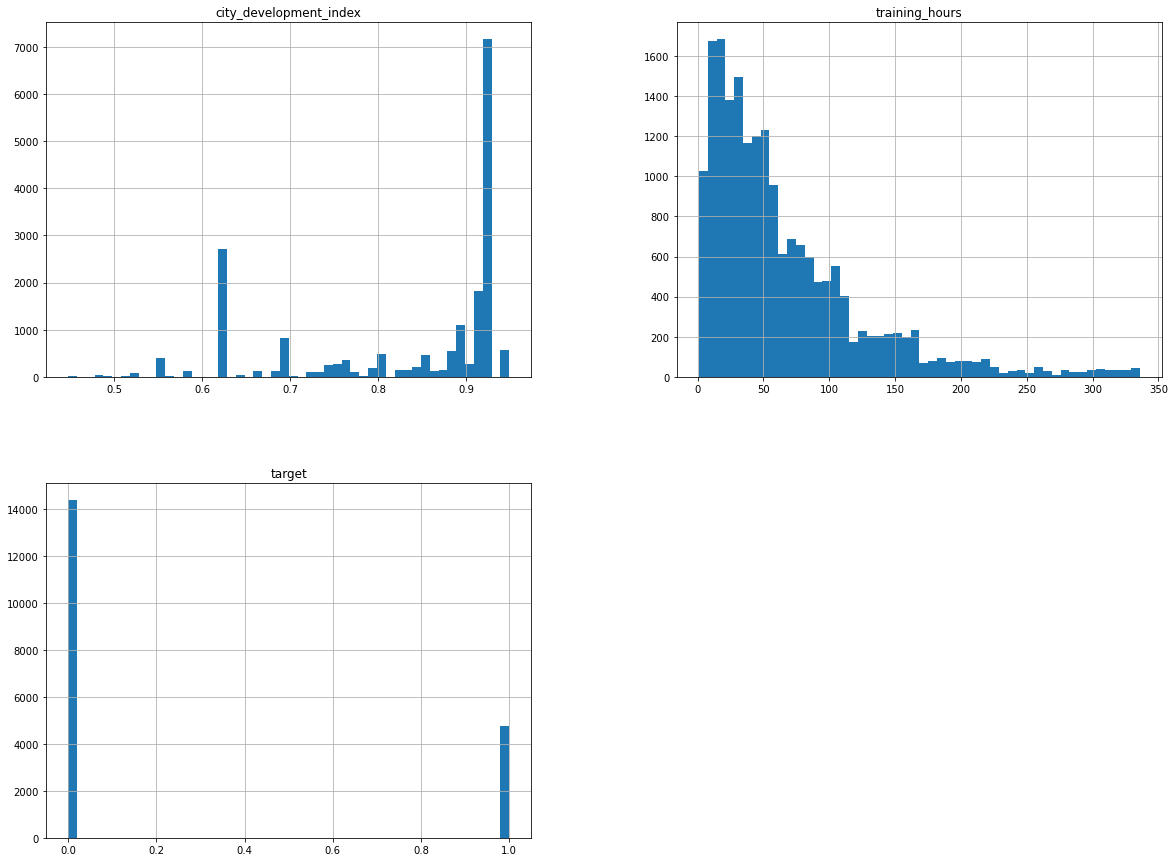

In [7]:
df.hist(bins=50,figsize=(20,15))
plt.show

### Lets use log transformation on 'training hours' and check the histograms

<function matplotlib.pyplot.show(close=None, block=None)>

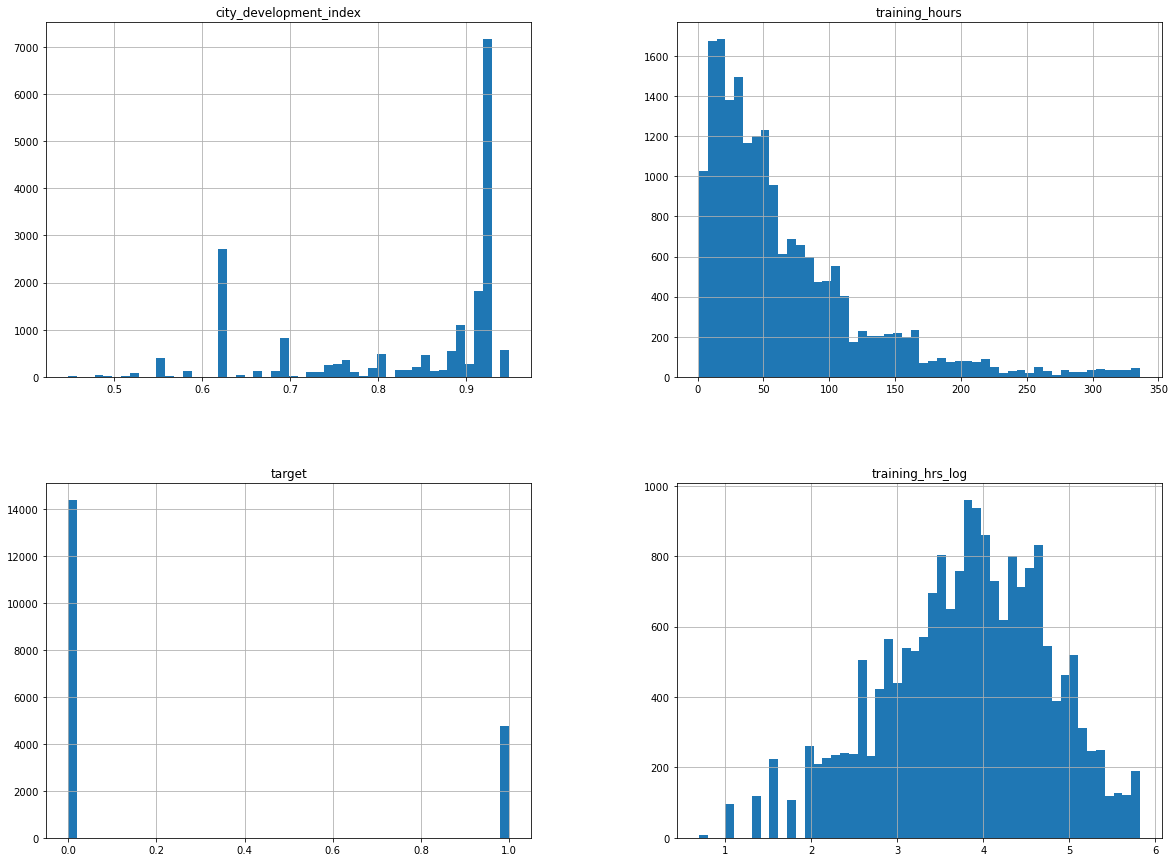

In [8]:
df['training_hrs_log'] = np.log1p(df['training_hours'])
df.hist(bins=50,figsize=(20,15))
plt.show

### This is better, we can remove the training hours column

In [9]:
df.drop('training_hours',axis = 1, inplace= True)

### Let's explore some categorical features to see if there are any recognizable patterns

In [10]:
df[['target','gender']].groupby('gender').mean().sort_values(by='target', ascending = False)

,target
gender,
Female,0.263328
Other,0.261780
Male,0.227819


In [11]:
df[['target','company_size']].groupby('company_size').mean().sort_values(by='target', ascending = False)

,target
company_size,
10/49,0.233855
10000+,0.190688
5000-9999,0.181172
50-99,0.176776
500-999,0.173318
<10,0.171254
100-500,0.161416
1000-4999,0.150602


In [12]:
df[['target','company_type']].groupby('company_type').mean().sort_values(by='target', ascending = False)

,target
company_type,
Other,0.239669
Early Stage Startup,0.235489
Public Sector,0.219895
NGO,0.186180
Pvt Ltd,0.180809
Funded Startup,0.139860


In [13]:
df[['target','enrolled_university']].groupby('enrolled_university').mean().sort_values(by='target', ascending = False)

,target
enrolled_university,
Full time course,0.380889
Part time course,0.252087
no_enrollment,0.211406


In [14]:
df[['target','education_level']].groupby('education_level').mean().sort_values(by='target', ascending = False) 

,target
education_level,
Graduate,0.279790
Masters,0.214400
High School,0.195340
Phd,0.140097
Primary School,0.133117


In [15]:
df[['target','relevent_experience']].groupby('relevent_experience').mean().sort_values(by='target', ascending = False) 

,target
relevent_experience,
No relevent experience,0.338427
Has relevent experience,0.214690


<AxesSubplot:xlabel='gender'>

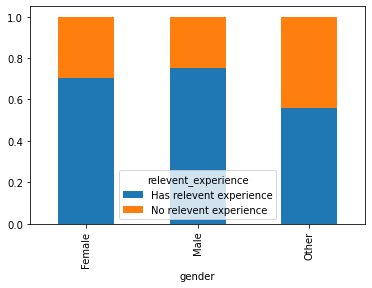

In [16]:
gender_cnts = pd.crosstab(df.gender, df.relevent_experience)
gender_pcts = gender_cnts.div(gender_cnts.sum(1).astype(float), axis=0)
gender_pcts.plot(kind='bar', stacked=True)

### check cardinality of categorical columns

In [17]:
object_cols = df.dtypes[df.dtypes=='object'].index.tolist()

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('relevent_experience', 2),
 ('gender', 3),
 ('enrolled_university', 3),
 ('education_level', 5),
 ('major_discipline', 6),
 ('company_type', 6),
 ('last_new_job', 6),
 ('company_size', 8),
 ('experience', 22),
 ('city', 123)]

### City has 123 unique value so has high cardinality. Since we already have city development index we can remove column 'city' from the dataset.

### Experience has 22 unique values and has high cardinality. Let's look at that later

In [18]:
df.drop('city',axis = 1, inplace= True)

### Split the datset into train and test

In [19]:
df.sample(frac=1, random_state=10).reset_index(drop=True)
train, test = train_test_split(df, test_size=0.2,random_state=10)
print(train['target'].value_counts())
print(test['target'].value_counts())

0.0    11478
1.0     3848
Name: target, dtype: int64
0.0    2903
1.0     929
Name: target, dtype: int64


In [20]:
train_y = train['target']
test_y = test['target']
train_X = train.drop('target', axis=1)
test_X = test.drop('target', axis=1)
train_X.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hrs_log
620,0.926,Male,No relevent experience,no_enrollment,High School,NaN,5,50-99,Pvt Ltd,2,5.549076
4642,0.878,Male,Has relevent experience,no_enrollment,Graduate,STEM,4,10000+,Pvt Ltd,1,3.433987
16366,0.920,Male,Has relevent experience,no_enrollment,Graduate,Arts,2,1000-4999,Pvt Ltd,2,3.850148
4294,0.893,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,10/49,Pvt Ltd,2,4.025352
3180,0.925,Female,Has relevent experience,no_enrollment,Phd,STEM,>20,100-500,Funded Startup,2,3.367296


### Let's see what going on with 'Experience' column 

In [21]:
train_X['experience'].value_counts()

>20    2639
5      1141
4      1132
3      1070
6       965
2       921
7       810
10      786
9       766
8       643
15      563
11      526
14      458
1       442
<1      422
16      420
12      396
13      320
17      278
19      242
18      217
20      114
Name: experience, dtype: int64

### Function to create reduced number of categories for experience column

In [22]:
def ExperienceBuckets(X):
    X.loc[X['experience'] == '>20', 'experience'] = '22'
    X.loc[X['experience'] == '<1', 'experience'] = '0.5'
    X['experience'] = pd.to_numeric(X['experience'])
    
    conditions = [
    (X['experience'] <1),
    (X['experience'] <= 5),
    (X['experience'] > 5) & (X['experience'] <= 10),
    (X['experience'] > 10) & (X['experience'] <= 15),
    (X['experience'] > 15) & (X['experience'] <= 20),
    (X['experience'] >20)]
    
    # create a list of the values we want to assign for each condition
    #values = ['<1', '1-5', '5-10', '10-15', '15-20', '>20']
    values = [1, 2, 3, 4, 5, 6]
    
    # create a new column and use np.select to assign values to it using our lists as arguments
    X['experience_ord'] = np.select(conditions, values)
    return X


In [23]:
train_X = ExperienceBuckets(train_X)
test_X = ExperienceBuckets(test_X)
print(train_X.head())
print(test_X.head())

       city_development_index  gender      relevent_experience  \
620                     0.926    Male   No relevent experience   
4642                    0.878    Male  Has relevent experience   
16366                   0.920    Male  Has relevent experience   
4294                    0.893    Male  Has relevent experience   
3180                    0.925  Female  Has relevent experience   

      enrolled_university education_level major_discipline  experience  \
620         no_enrollment     High School              NaN         5.0   
4642        no_enrollment        Graduate             STEM         4.0   
16366       no_enrollment        Graduate             Arts         2.0   
4294        no_enrollment        Graduate             STEM         5.0   
3180        no_enrollment             Phd             STEM        22.0   

      company_size    company_type last_new_job  training_hrs_log  \
620          50-99         Pvt Ltd            2          5.549076   
4642        10000+  

In [24]:
train_X.drop('experience', axis = 1, inplace = True)
test_X.drop('experience', axis = 1, inplace = True)

### We can convert education level category to numerical

In [25]:
train_X['education_level'].value_counts()

Graduate          9314
Masters           3495
High School       1592
Phd                320
Primary School     236
Name: education_level, dtype: int64

In [26]:
education_mapping = {"Primary School": 1, "High School": 2, "Graduate":3, "Masters": 4, "Phd":5}

In [27]:
train_X['education_level'] = train_X['education_level'].map(education_mapping)
test_X['education_level'] = test_X['education_level'].map(education_mapping)
train_X.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,training_hrs_log,experience_ord
620,0.926,Male,No relevent experience,no_enrollment,2.0,NaN,50-99,Pvt Ltd,2,5.549076,2
4642,0.878,Male,Has relevent experience,no_enrollment,3.0,STEM,10000+,Pvt Ltd,1,3.433987,2
16366,0.920,Male,Has relevent experience,no_enrollment,3.0,Arts,1000-4999,Pvt Ltd,2,3.850148,2
4294,0.893,Male,Has relevent experience,no_enrollment,3.0,STEM,10/49,Pvt Ltd,2,4.025352,2
3180,0.925,Female,Has relevent experience,no_enrollment,5.0,STEM,100-500,Funded Startup,2,3.367296,6


### Get the numeric and category coloumns

In [28]:
attribs = train_X.columns
num_attribs = list(train_X._get_numeric_data().columns)
cat_attribs = list(set(attribs) - set(num_attribs))
print(num_attribs)
print(cat_attribs)

['city_development_index', 'education_level', 'training_hrs_log', 'experience_ord']
['major_discipline', 'last_new_job', 'relevent_experience', 'company_type', 'enrolled_university', 'gender', 'company_size']


### Create DataFrame selector class


In [29]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

### Create pipelines for numerical and category columns

In [30]:
num_pipeline = Pipeline([('Selector', DataFrameSelector(num_attribs)), ('imputer',SimpleImputer(strategy='median')),\
                        ('std_scaler',StandardScaler())])

cat_pipeline = Pipeline([('Selector', DataFrameSelector(cat_attribs)), ('category_imputer',SimpleImputer(strategy='constant',fill_value="unknown")),\
                                                 ('one_hot_encoder',OneHotEncoder(drop="if_binary"))])

### Complete pipeline

In [31]:
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),("cat_pipeline", cat_pipeline)])

### prepare the training set by fitting and transforming using the complete pipeline

In [32]:
train_prepared = full_pipeline.fit_transform(train_X)
train_prepared

<15326x43 sparse matrix of type '<class 'numpy.float64'>'
	with 157539 stored elements in Compressed Sparse Row format>

## Training a logistic regression model

In [33]:
log_reg = LogisticRegressionCV(cv=10,max_iter=1000, class_weight={0:0.50}).fit(train_prepared, train_y)

In [34]:
predictions = log_reg.predict(train_prepared)

In [35]:
print(log_reg.score(train_prepared, train_y))
print(roc_auc_score(train_y,predictions))

0.7728043847057289
0.681958281213378


In [36]:
test_prepared = full_pipeline.transform(test_X)

In [37]:
predictions_test = log_reg.predict(test_prepared)

In [38]:
print(log_reg.score(test_prepared, test_y))
print(roc_auc_score(test_y,predictions_test))

0.774008350730689
0.6788345229147532


In [39]:
confusion_matrix(predictions_test, test_y)

array([[2507,  470],
       [ 396,  459]], dtype=int64)

### Model is performing poorly. Lets check the learning curves. This is standard code provided on sklearn website

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

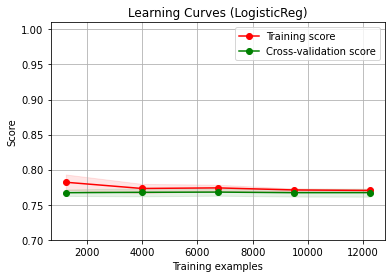

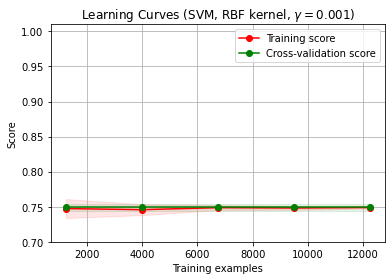

In [90]:
title = "Learning Curves (LogisticReg)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, train_prepared, train_y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, train_prepared, train_y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

### Both models are underfitting but Logistic regression performs slightly better. Adding more data will not help. 

### Let's try Random Forest

In [41]:
rf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=0)
print(np.mean(cross_val_score(rf, train_prepared, train_y, cv=5)))

0.7828524393734788


### Re-try with hyper parameter tuning

In [42]:
param_grid = {'n_estimators': [50,100,150],'max_depth': [10,15,20]}

In [43]:
rf = RandomForestClassifier(random_state=0)
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(train_prepared, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [50, 100, 150]})

In [44]:
grid_rf.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [45]:
best_grid = grid_rf.best_estimator_
predictions = best_grid.predict(train_prepared)

In [46]:
print(best_grid.score(train_prepared, train_y))
print(roc_auc_score(train_y,predictions))

0.9008873809213102
0.8435669801652551


In [47]:
predictions_test = best_grid.predict(test_prepared)
print(best_grid.score(test_prepared, test_y))
print(roc_auc_score(test_y,predictions_test))

0.7867954070981211
0.6803204954453042


### Random Forest performs well on training data but doesn't generalize well on test data.

### Let's try XGBoost

In [48]:
xgb_model = XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.002, use_label_encoder=False).fit(train_prepared, train_y)

[11:22:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
predictions = xgb_model.predict(train_prepared)

In [50]:
print(xgb_model.score(train_prepared, train_y))
print(roc_auc_score(train_y,predictions))

0.830745138979512
0.781276954303614


In [51]:
predictions_test = xgb_model.predict(test_prepared)

In [52]:
print(xgb_model.score(test_prepared, test_y))
print(roc_auc_score(test_y,predictions_test))

0.7907098121085595
0.7231615562683938


### This is little better although model is overfitting on the training data. Let's check the confusion matrix

In [53]:
confusion_matrix(predictions_test, test_y)

array([[2480,  379],
       [ 423,  550]], dtype=int64)

### This is an okay model. We can simplify the model a little so that it generalizes better on the test data

In [90]:
xgb_model2 = XGBClassifier(max_depth=6, n_estimators=50, learning_rate=0.01, use_label_encoder=False).fit(train_prepared, train_y)

[11:48:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [91]:
predictions2 = xgb_model2.predict(train_prepared)

In [92]:
print(xgb_model2.score(train_prepared, train_y))
print(roc_auc_score(train_y,predictions2))

0.8071903954064987
0.7513855485627572


In [93]:
predictions_test2 = xgb_model2.predict(test_prepared)

In [94]:
print(xgb_model2.score(test_prepared, test_y))
print(roc_auc_score(test_y,predictions_test2))

0.7920146137787056
0.7273165319866943


In [95]:
confusion_matrix(predictions_test2, test_y)

array([[2476,  370],
       [ 427,  559]], dtype=int64)

### This is closer to training results hence generalizing better

### Let's check feature importance

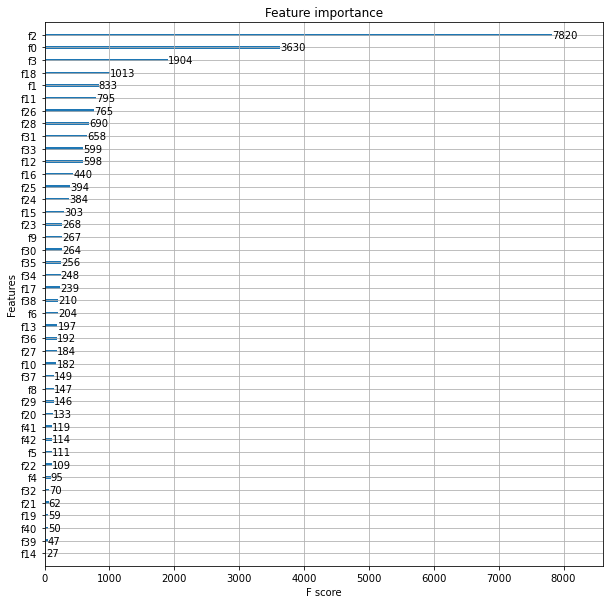

In [96]:
ax = plot_importance(xgb_model)
fig = ax.figure
fig.set_size_inches(10, 10)

### Training hours and city development index are the best predictors followed by total experience

#### What we have is a decent but not a great model. We can try to improve the performance by using voting classifiers or stacking that would combine various individual classifiers to give better results. However, I do not expect a lot of improvement because some very important features such as employee satisfaction survey data, employee performance data, manager data, time since last promotion etc. that might be better predictors are not available.